# Partial wave analysis notebook
In the notebook I perform the mass-independent partial wave analysis in a single $m_{3\pi}$ bin.
 1. Prepare data: $M_{3\pi} \in [2.3, 2.31]\,$GeV
 2. Perpare Model: 88 waves, coherence $\text{FLAT}\otimes(\epsilon=+)\otimes(\epsilon=-)\otimes(\epsilon=-)$
 3. Perform fit: gradient based minimization in 186 dims

In [1]:
using JLD
using Plots

In [2]:
# push!(LOAD_PATH,pwd()*"\\src")
push!(LOAD_PATH,pwd()*"/src")

3-element Array{Any,1}:
 "/localhome/mikhasenko/Tools/julia/usr/local/share/julia/site/v0.6"
 "/localhome/mikhasenko/Tools/julia/usr/share/julia/site/v0.6"      
 "/home/mikhasenko/Documents/pwa_from_scratch/src"                  

In [3]:
# workspace()
using DalitzPlotAnalysis
using amplitudes_compass

In [4]:
# mm = readdlm("C:\\Users\\mikha\\cernbox\\tmp\\2300.mc.txt");

## First step: data preparation

In [5]:
function precalculate_compass_basis(fin,fout)
    mm = readdlm(fin)#[1:1000,:];
    # fast code
    m2 = [COMPASS_wave(i,mm[e,:]...) for e=1:size(mm,1), i=1:88];
    # surprisingly filling array is slower
#     const m2 = Matrix{Complex{Float64}}(size(mm,1),88)
#     for e=1:size(mm,1), i=1:88
#         m2[e,i] = COMPASS_wave(i,mm[e,:]...)
#     end
    save(fout,"real",real(m2),"imag",imag(m2))
end
function read_precalc_basis(fname)
    ld = load(fname)
    ld["real"]+1im*ld["imag"]
end

read_precalc_basis (generic function with 1 method)

### Precalculate basis functions on Data events and MC events
The basis functions are some complex functions of kinematical variables $\tau = s,(\sigma_1,\Omega_1,\Omega_{23})$.

We calculate and save to the file the following matrix $N_\text{ev}\times 88$
$$
[\,\Psi_i(\tau_e)\,],\quad \forall i = 1,\dots,88,\quad e = 1,\dots,N_\text{ev}
$$

In [6]:
# Windows
# @time precalculate_compass_basis("C:\\Users\\mikha\\cernbox\\tmp\\2300.mc.txt", "mc.jld")
# Linux
# @time precalculate_compass_basis(ENV["HOME"]*"/cernbox/tmp/pwa_from_scratch_data/2300.mc.txt", "mc.jld")
# 822.936608 seconds (2.97 G allocations: 92.770 GiB, 1.51% gc time)

In [7]:
# Windows
# @time precalculate_compass_basis("C:\\Users\\mikha\\cernbox\\tmp\\2300.rd.txt", "rd.jld")
# Linux
# @time precalculate_compass_basis(ENV["HOME"]*"/cernbox/tmp/pwa_from_scratch_data/2300.rd.txt", "rd.jld")
# 145.960972 seconds (816.66 M allocations: 23.646 GiB, 2.47% gc time)

In [8]:
const PsiMC = read_precalc_basis("mc.jld")#[1:1000,:];

In [9]:
@time sum_mat = [sum(PsiMC[e,i]'*PsiMC[e,j] for e in 1:size(PsiMC,1)) for i=1:88, j=1:88]/size(PsiMC,1);

  7.814014 seconds (117.65 k allocations: 6.139 MiB)


In [10]:
sum_mat_n = [sum_mat[i,j]/sqrt(sum_mat[i,i]*sum_mat[j,j]) for i=1:88, j=1:88];

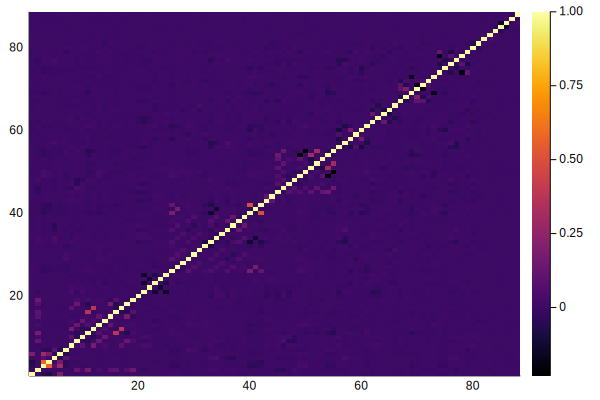

In [11]:
heatmap(real(sum_mat_n))

## Second step: Model preparation
Coherence matrix has block-diagonal form
$$
\begin{pmatrix}
\text{FLAT} && &\\
&\epsilon = + & &\\
& &\epsilon = - &\\
& & &\epsilon = -\\
\end{pmatrix}
$$

In [12]:
waves = readdlm(pwd()*"/src/wavelist_formated.txt");

In [13]:
const noϵ = [i==1 for i=1:size(waves[:,6],1)]
const posϵ = [ϵ=="+" for ϵ in waves[:,6]]
const negϵ = [ϵ=="-" for ϵ in waves[:,6]]
## decomp
sum(noϵ)+sum(posϵ)+sum(negϵ) == length(waves[:,6])
block(i) = 1*noϵ[i]+2*posϵ[i]+3*negϵ[i]

block (generic function with 1 method)

In [14]:
COH = [block(i)==block(j) for i=1:88, j=1:88];
const COHc = convert(Array{Complex{Float64},2},COH);

In [15]:
function COHsq(X::Vector{Complex{Float64}})
    sum(abs2(sum(X[bl])) for bl in [noϵ,posϵ,negϵ])
end
function COHts(X::Vector{Complex{Float64}})
    sum(sum(X[bl])*bl for bl in [noϵ,posϵ,negϵ])
end

COHts (generic function with 1 method)

In [16]:
# @time for i in 1:1000
#     COHsq(BF[i,:])
# end
# # 0.001938 seconds (16.49 k allocations: 3.334 MiB)
# @time for i in 1:1000
#     BF[3,:]'*COHts(BF[3,:])
# end
# # 0.002940 seconds (22.00 k allocations: 11.856 MiB)

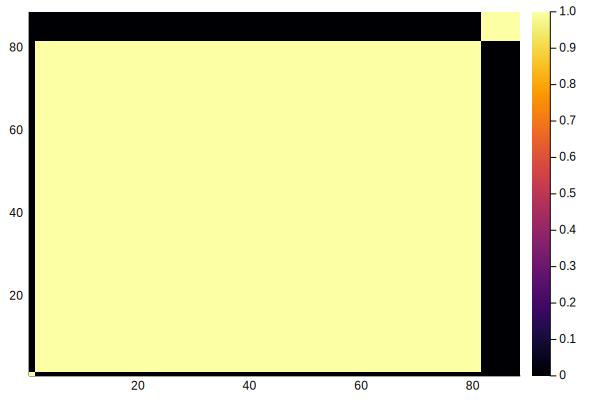

In [17]:
heatmap(COH)

### Map of parameters

In [18]:
const ModelBlocks = [noϵ,posϵ,negϵ,negϵ]
Trel = let vect=[]
    temp = []
    numb = []
    for bl in ModelBlocks
        push!(temp,false)
        push!(temp,[true for i=1:(sum(bl)-1)]...)
        push!(numb,collect(1:88)[bl]...)
    end 
    Trel = zeros(Complex{Float64},88,sum(temp+1))
    global Tmap = fill(0,2,sum(temp+1))
    count=1
    for (i,b) in enumerate(temp)
        Trel[numb[i],count] = 1.0;
        Tmap[1,count] = numb[i]
        count+=1
        if b
            Trel[numb[i],count] = 1.0im;
            Tmap[2,count] = numb[i];
            count+=1
        end
    end
    Trel
#     numb
end;

In [19]:
Tmap

2×186 Array{Int64,2}:
 1  2  3  0  4  0  5  0  6  0  7  0  8  …   0  85   0  86   0  87   0  88   0
 0  0  0  3  0  4  0  5  0  6  0  7  0     84   0  85   0  86   0  87   0  88

In [20]:
const TT = Trel;
const TM = Tmap;

In [21]:
function TTm(p)
    c = fill(0.0+0.0im,88)
    for i in 1:size(TM,2)
        TM[1,i]!=0 && (c[TM[1,i]]+=1.0*p[i])
        TM[2,i]!=0 && (c[TM[2,i]]+=1.0im*p[i])
    end
    c
end

TTm (generic function with 1 method)

In [22]:
# Test either TTm is faster then matrix multiplication
# @time for i=1:1000
#     TTm(rand(size(TT,2)))
# end
# # 0.001981 seconds (2.00 k allocations: 2.975 MiB)
# @time for i=1:1000
#     TT*rand(size(TT,2))
# end
# # 0.010212 seconds (3.00 k allocations: 5.966 MiB)

In [23]:
# function get_form(B)
#     @inbounds m = B.*TT;
#     @inbounds v = m'COHc*m
#     v
# end
# # @time const BFE = get_form.([BF[e,:] for e=1:size(BF,1)]);

In [24]:
const Bmat = sum_mat;
@time const TBmatT = real(TT'*(Bmat.*COHc)*TT);

  2.045559 seconds (1.30 M allocations: 63.862 MiB, 1.71% gc time)


### Real data

In [25]:
const BF = read_precalc_basis("rd.jld")#[1:10000,:]
const Nd = size(BF,1);

In [26]:
function get_form(B)
    m = B.*TT;
    v = m'COHc*m
    v
end

get_form (generic function with 1 method)

In [27]:
# sR = open("recalc1.re.bin","w+") # or "r"
# sI = open("recalc1.im.bin","w+") # or "r"
# Ar = Mmap.mmap(sR, Matrix{Float64}, (size(TT,2)*Nd, size(TT,2)));
# Am = Mmap.mmap(sI, Matrix{Float64}, (size(TT,2)*Nd, size(TT,2)));

In [28]:
# @time let d = size(TT,2)
#     for e = 1:Nd
#         matr = get_form(BF[e,:])
#         Ar[((e-1)*d+1):(e*d),:] .= real(matr)
#         Am[((e-1)*d+1):(e*d),:] .= imag(matr)        
#     end
# end

In [29]:
# function preBFE(e)
#     d = size(TT,2)
#     Ar[((e-1)*d+1):(e*d),:] .+ 1im*Am[((e-1)*d+1):(e*d),:]
# end

In [30]:
# @time for i in 1:10000
#     preBFE(i);
# end

Likelihood functions

In [31]:
function LLH(pars::Vector{Float64})
    res = sum(log(real(begin
#                     m = get_form(BF[e,:])
                    cv = BF[e,:].*(TTm(pars))
                    COHsq(cv)
                    end)) for e in 1:Nd)
    - res + real(pars'*TBmatT*pars) * Nd
end
function getDv(psi::Vector{Complex{Float64}}, pars::Vector{Float64})
    cv = psi.*(TTm(pars))
    cvv = COHts(psi.*(TTm(pars)))
    v = [(TM[1,i] == 0 ? 0.0im : cvv[TM[1,i]]*psi[TM[1,i]]') - 1.0im*
         (TM[2,i] == 0 ? 0.0im : cvv[TM[2,i]]*psi[TM[2,i]]') for i in 1:size(TM,2)]
    return real(v)
end
function dLLH(pars::Vector{Float64})
    resP = sum(2real(begin
                    v = getDv(BF[e,:],pars)
                    v / (pars'*v)
                end)  for e in 1:Nd)
    - resP + 2real(TBmatT*pars)* Nd 
end
function LLH_and_GRAD!(pars::Vector{Float64}, grad::Vector{Float64})
    val = 0.0; grad .= 0.0
    for e in 1:Nd
        v = getDv(BF[e,:],pars)
        vale = pars'*v
        grad .-= v / vale
        val -= log(vale);
    end
    grad .*= 2.0
    # println(val)
    BB = TBmatT*pars;
    val += pars'*BB * Nd;
    grad .+= BB* (2Nd);
    return val;
end

LLH_and_GRAD! (generic function with 1 method)

In [32]:
test_t = rand(size(TT,2));

In [33]:
@time LLH(test_t)
@time dLLH(test_t)
@time g1 = let gra = Vector{Float64}(186)
    v = LLH_and_GRAD!(test_t,gra)
    @show v
    gra
end
# @time g2 = let gra = Vector{Float64}(186)
#     v = LLH_and_GRAD!(test_t,gra)
#     @show v
#     gra
# end
# max((g1-g2)...)

  0.857841 seconds (1.73 M allocations: 516.632 MiB, 33.24% gc time)
  1.417948 seconds (2.78 M allocations: 2.047 GiB, 14.94% gc time)
v = 2.0476868667143993e7
  1.061571 seconds (2.44 M allocations: 1.788 GiB, 17.05% gc time)


186-element Array{Float64,1}:
 37064.3      
     4.13429e5
     1.40376e5
     1.12248e5
     1.74676e5
     1.13409e5
     3.48225e5
     1.89274e6
  -217.379    
 43332.7      
 20973.8      
 12607.0      
     2.34049e6
     ⋮        
     2.48615e6
     1.36185e6
     1.32309e6
     2.46264e6
     3.07366e6
     1.1837e6 
 -5109.14     
 11754.1      
 32820.5      
 28712.6      
 63832.0      
  9279.96     

In [34]:
# function LLH(pars::Vector{Float64})
#     res = sum(log(real(begin
# #                     m = get_form(BF[e,:])
#                     cv = BF[e,:].*(TTm(pars))
#                     COHsq(cv)
#                     end)) for e in 1:Nd)
#     - res + real(pars'*TBmatT*pars) * Nd
# end
# function dLLH(pars::Vector{Float64})
#     resP = sum(2real(begin
#                     m = get_form(BF[e,:])
#                     v = m*pars
#                     v / (pars'*v)
#                 end)  for e in 1:Nd)
#     - resP + 2real(TBmatT*pars)* Nd 
# end
# function LLH_and_GRAD!(pars::Vector{Float64}, grad::Vector{Float64})
#     val = 0.0; grad .= 0.0;
#     for e in 1:Nd
#         m = get_form(BF[e,:])
#         v = m*pars
#         sc = real(pars'*v)
#         val -= log(sc)
#         grad .-= (2real(v) ./ sc)
#     end
# #     println(val)
#     BB = TBmatT*pars;
#     val += real(pars'*BB) * Nd;
#     grad .+= 2real(BB)* Nd;
#     return val;
# end

In [35]:
using NLopt

In [36]:
function minimize(; verbose::Int=0, startpars::Vector{Float64} = rand(size(TT,2)))
#     function abs_inverse(x::Vector, grad::Vector) 
#         v = LLH(x)
#         if length(grad) > 0
#             grad[:] = dLLH(x)
#         end        
#         verbose==1 && println(v)
#         verbose==2 && println("\n------\n$x\n$grad\n->$v")
#         v
#     end
    function abs_inverse(x::Vector, grad::Vector) 
        if length(grad) > 0
            v = LLH_and_GRAD!(x,grad)
        else
            v = LLH(x)
        end
        verbose==1 && @show v
        verbose==2 && @show v,x
        verbose==3 && @show v,grad
        return v;
    end

    # find minimum which of course suppose t o be zero
#     opt = Opt(:LN_COBYLA, 88)
    opt = Opt(:LD_LBFGS, size(TT,2)) # try LD_LBFGS || LD_MMA
    xtol_rel!(opt,1e-4)
    maxeval!(opt,500000)

    min_objective!(opt, abs_inverse)

    (minf,pars,ret) = optimize(opt, startpars)#rand(size(TT,2)))
    println("got $minf at $pars = [m, Γ] after some iterations (returned $ret)")
    pars
end

minimize (generic function with 1 method)

In [37]:
# @time minpars = minimize(verbose=1, startpars=test_t)

In [38]:
# writedlm("min1e5.txt", minpars2)
minpars0 = vcat(readdlm("min1e5.txt")...);

In [39]:
@time minpars2 = minimize(verbose=1, startpars=minpars0)

v = 8145.742057445372
v = 6.16147602424961e14
v = 6.158666501950851e10
v = 5.645040365172557e6
v = 7892.375335324119
v = 7770.988278655132
v = 7686.385525963662
v = 7603.077517138372
v = 7491.0670441072725
v = 7475.906089145923
v = 7384.061701682513
v = 7358.16429497549
v = 7322.234884569334
v = 7290.8828902652895
v = 7254.607117356369
v = 7227.95420070659
v = 7203.449984964245
v = 7176.278685020778
v = 7161.325946834404
v = 7151.534347913432
v = 7141.915620454762
v = 7129.999169363582
v = 7120.267622090454
v = 7107.223300816098
v = 7101.823555537107
v = 7096.783615681023
v = 7091.3165116590535
v = 7084.8212788930105
v = 7078.449574731552
v = 7071.854488464043
v = 7063.63854358597
v = 7055.702038903619
v = 7050.732118501124
v = 7043.594049656487
v = 7038.399695692366
v = 7032.354523806644
v = 7027.17000166433
v = 7023.662058779708
v = 7020.189469140605
v = 7014.772926396443
v = 7010.487357210746
v = 7008.393136806539
v = 7004.590801683327
v = 7002.555953466377
v = 7000.346045729457
v =

v = 6800.806100982052
v = 6800.7848649040825
v = 6800.762041733513
v = 6800.749230682064
v = 6800.736475172496
v = 6800.744958474461
v = 6800.730578211951
v = 6800.725919358374
v = 6800.715573184207
v = 6800.709251164051
v = 6800.696935807398
v = 6800.690944987786
v = 6800.684853554543
v = 6800.683271390109
v = 6800.679941000431
v = 6800.677620116228
v = 6800.673211176865
v = 6800.667493514135
v = 6800.65992824726
v = 6800.65447294162
v = 6800.645621410818
v = 6800.635532184708
v = 6800.625033635253
v = 6800.616007726116
v = 6800.614049288124
v = 6800.609315103604
v = 6800.608116013595
v = 6800.606808393044
v = 6800.604374898365
v = 6800.598797417217
v = 6800.594233024603
v = 6800.591707849337
v = 6800.589291488577
v = 6800.58468846936
v = 6800.579594808078
v = 6800.575483495573
v = 6800.5729663963575
v = 6800.571720085049
v = 6800.569214044677
v = 6800.565394737365
v = 6800.560652194021
v = 6800.558149207849
v = 6800.557051156531
v = 6800.555931531155
v = 6800.554939933252
v = 6800.55

186-element Array{Float64,1}:
 -0.464776   
  0.0369943  
  0.021223   
 -0.0375417  
  0.00244903 
 -3.08076e-5 
 -0.000574128
  0.0018267  
 -0.0183436  
  0.0147812  
  0.1141     
  0.117385   
  0.00690976 
  ⋮          
  0.043325   
  0.195578   
  0.196652   
 -0.132558   
 -0.0615081  
 -0.0280207  
  0.0306475  
 -0.0247505  
 -0.452179   
  0.140425   
 -0.126913   
 -0.238809   

## Compare disributions

In [40]:
function swap_kin_parameters(κ1::Vector{Float64})
    τ = change_basis(κ1[2:end]...,0.13957^2,0.13957^2,0.13957^2,κ1[1])
    κ3 = zero(κ1)
    κ3[1] = κ1[1]
    κ3[2] = τ[1]
    κ3[3] = τ[2]
    κ3[4] = τ[3]
    κ3[5] = -τ[4] # angle of the oposite particle
    κ3[6] = τ[5]+π # angle of the oposite particle
    κ3
end

swap_kin_parameters (generic function with 1 method)

In [41]:
# const MCD = readdlm("C:\\Users\\mikha\\cernbox\\tmp\\2300.mc.txt");
const MC1 = readdlm(ENV["HOME"]*"/cernbox/tmp/pwa_from_scratch_data/2300.mc.txt");

In [42]:
@time const MC3 = hcat([swap_kin_parameters(MC1[e,:]) for e in 1:size(MC1,1)]...)';

  2.717421 seconds (23.79 M allocations: 889.616 MiB, 24.67% gc time)


In [43]:
COMPASS_wave(5,MC1[1,:]...)-COMPASS_wave(5,MC3[1,:]...)

-3.3306690738754696e-16 + 1.3877787807814457e-17im

In [44]:
@time weights = let mpars = TT*minpars2
    [COHsq(PsiMC[i,:].*mpars) for i in 1:size(PsiMC,1)];
    end;

  1.708110 seconds (7.81 M allocations: 2.008 GiB, 27.28% gc time)


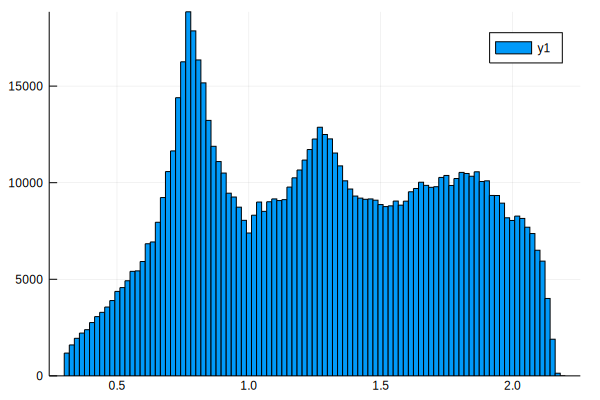

In [45]:
histogram(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights), bins=(linspace(0.3,2.2,100)))

In [46]:
const DT1 = readdlm(ENV["HOME"]*"/cernbox/tmp/pwa_from_scratch_data/2300.rd.txt");

In [47]:
@time const DT3 = hcat([swap_kin_parameters(DT1[e,:]) for e in 1:size(DT1,1)]...)';

  0.456778 seconds (4.54 M allocations: 169.196 MiB, 14.15% gc time)


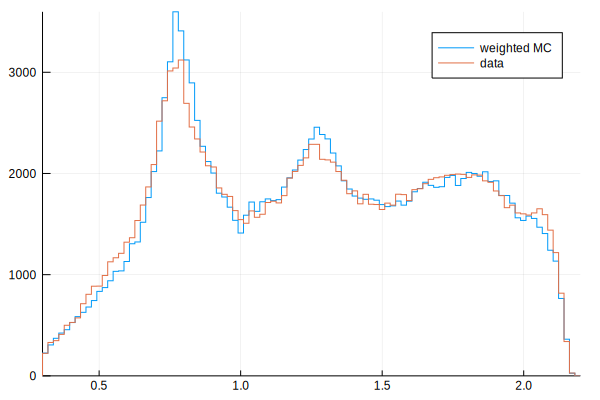

In [48]:
stephist(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC")
stephist!(sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data") 

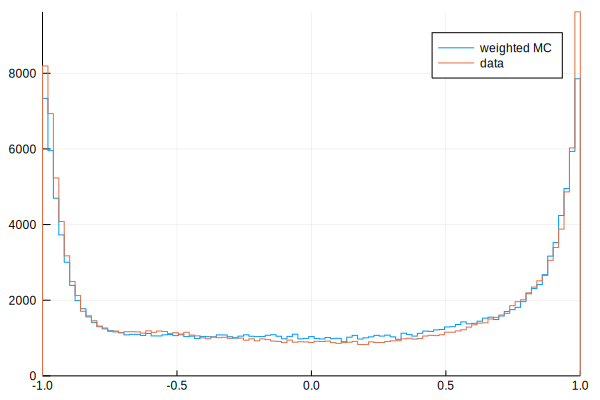

In [49]:
stephist(vcat(MC1[:,3],MC3[:,3]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-1,1,100),lab="weighted MC")
stephist!(vcat(DT1[:,3],DT3[:,3]), bins=linspace(-1,1,100),lab="data") 

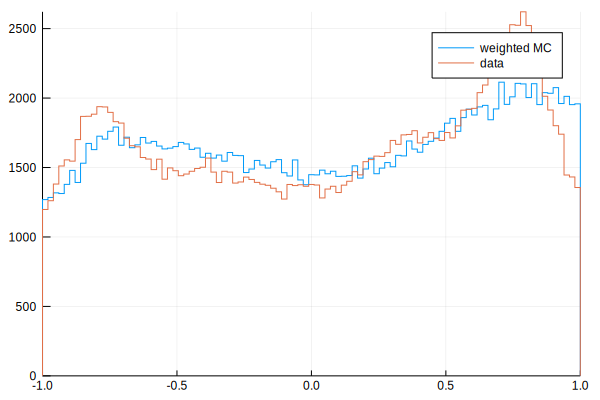

In [50]:
stephist(vcat(MC1[:,5],MC3[:,5]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-1,1,100),lab="weighted MC")
stephist!(vcat(DT1[:,5],DT3[:,5]), bins=linspace(-1,1,100),lab="data") 

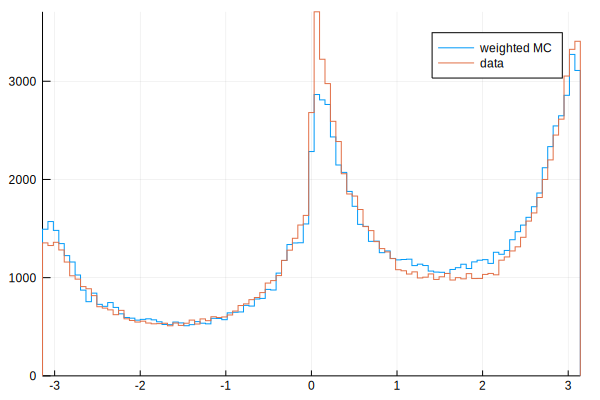

In [51]:
stephist(vcat(MC1[:,6],MC3[:,6]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-π,π,100),lab="weighted MC")
stephist!(vcat(DT1[:,6],DT3[:,6]), bins=linspace(-π,π,100),lab="data") 

### Plot individual components

In [69]:
isobars = [[w==p for w in waves[:,7]] for p in -2:3];

In [71]:
sum(isobars[1])

1

In [73]:
@time weightsI = let mpars = TT*minpars2
    [[COHsq(PsiMC[i,:].*mpars.*isobars[p]) for i in 1:size(PsiMC,1)] for p in 1:size(isobars,1)];
end;

158.305205 seconds (178.42 M allocations: 16.042 GiB, 1.70% gc time)


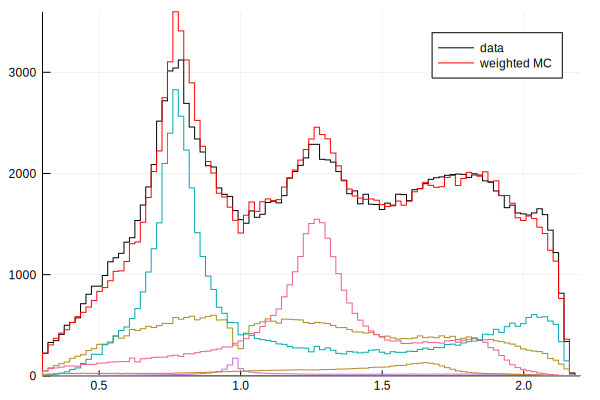

In [77]:
stephist(sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data",lc=:black) 
stephist!(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC",lc=:red)
for p in 1:size(isobars,1)
    stephist!(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weightsI[p],weightsI[p])/size(MC1,1)*size(DT1,1),
        bins=linspace(0.3,2.2,100),lab="")
end
plot!()